# Generating Images by SVD

1. Loading Images in matrix
2. Perform SVD
3. Generate new image matrix by first SVs
4. Display and save images

### 1. Loading Images in Matrix

In [ ]:
!pip install numpy
!pip install pillow

Importing Libraries

In [109]:
import numpy as np
from PIL import Image
import os

Images input and output directories

In [111]:
img_dir = os.path.join(os.path.abspath(os.path.pardir), 'img')
img_input_dir = os.path.join(img_dir, 'input')
img_output_dir = os.path.join(img_dir, 'output')

Load all the image files in input directory

Only .jpg, .jpeg, .png supported extensions

In [112]:
supported_extensions = ['.jpg', '.jpeg', 'png']

In [113]:
input_image_files = [filename for filename in os.listdir(img_input_dir) if filename.endswith(tuple(supported_extensions))]

input_image_files

['IMG_20150328_194414336.jpg', 'Zinnia Poolside In June.jpg']

Load the images in np array

In [114]:
image_matrices = {}

Load Image by Image.open

In [115]:
for input_image_file in input_image_files:
    image_matrices[input_image_file] = np.asarray(Image.open(os.path.join(img_input_dir, input_image_file)))
    print(f"Image {input_image_file} dimension: ", image_matrices[input_image_file].shape)

Image IMG_20150328_194414336.jpg dimension:  (600, 800)
Image Zinnia Poolside In June.jpg dimension:  (800, 600, 3)


### SVD on images

Functions to:
* Bring color channel axis to axis0 from axis2
* Bring color channel axis from axis0 to axis2

In [116]:
def color_channel_to_axis0(img_matrix: np.array) -> np.array:
    if(len(img_matrix.shape) == 2):
        return img_matrix # Is Grayscale
    elif((len(img_matrix.shape) == 3 and img_matrix.shape[2] <=4)):
        return np.stack([img_matrix[:, :, i] for i in range(img_matrix.shape[2])], axis=0)
    else:
        raise ValueError('Not in (width, height, n_colors) format')

In [117]:
def color_channel_to_axis2(img_matrix: np.array) -> np.array:
    if(len(img_matrix.shape) == 2):
        return img_matrix # Is Grayscale
    elif((len(img_matrix.shape) == 3 and img_matrix.shape[0] <=4)):
        return np.stack([img_matrix[i, :, :] for i in range(img_matrix.shape[0])], axis=2)
    else:
        raise ValueError('Not in (width, height, n_colors) format')

SVD on image matrix

In [118]:
def svd_image_matrix(img_matrix: np.array) -> any:
    return np.linalg.svd(img_matrix, full_matrices=False)

Bring Color Channel from Axis=2 to Axis=0

In [119]:
for img_file in image_matrices:
    image_matrices[img_file] = color_channel_to_axis0(image_matrices[img_file])
    print(f"Image {img_file} dimension: ", image_matrices[img_file].shape)

Image IMG_20150328_194414336.jpg dimension:  (600, 800)
Image Zinnia Poolside In June.jpg dimension:  (3, 800, 600)


Perform SVD on image matrices

In [120]:
svd_results = {}
for img_file in image_matrices:
    svd_results[img_file] = svd_image_matrix(image_matrices[img_file])

### Generate Image by SVs

In [121]:
def singular_image_matrix(svd_result:any, img_matrix: np.array, k:int=1) -> np.array:
    result = np.zeros(img_matrix.shape, dtype='float64')
    S = np.expand_dims(svd_result.S, axis=0) if svd_result.S.ndim == 1 else svd_result.S
    U = np.expand_dims(svd_result.U, axis=svd_result.U.ndim)
    Vh = np.expand_dims(svd_result.Vh, axis=svd_result.Vh.ndim - 1)
    for i in range(k):
        temp = np.linalg.matmul(np.take(U, i, axis=U.ndim-2), np.take(Vh, i, axis=Vh.ndim-3))
        result = result + np.expand_dims(S[:, i], axis=tuple(range(S[:, i].ndim, temp.ndim))) * temp
    return result

Number of Singular Vectors

In [122]:
n_sing_vecs = [1, 2, 4, 16]

In [123]:
generated_images = {}

In [124]:
for img_file in svd_results:
    generated_images[img_file] = {}
    for k in n_sing_vecs:
        generated_images[img_file][k] = color_channel_to_axis2(singular_image_matrix(svd_results[img_file], image_matrices[img_file], k))

Re-convert axis modified image to original image

In [125]:
for img_file in image_matrices:
    image_matrices[img_file] = color_channel_to_axis2(image_matrices[img_file])
    print(img_file, image_matrices[img_file].shape)

IMG_20150328_194414336.jpg (600, 800)
Zinnia Poolside In June.jpg (800, 600, 3)


### Display and save the images

In [ ]:
!pip install matplotlib

In [126]:
import matplotlib.pyplot as plt

Displaying IMG_20150328_194414336.jpg

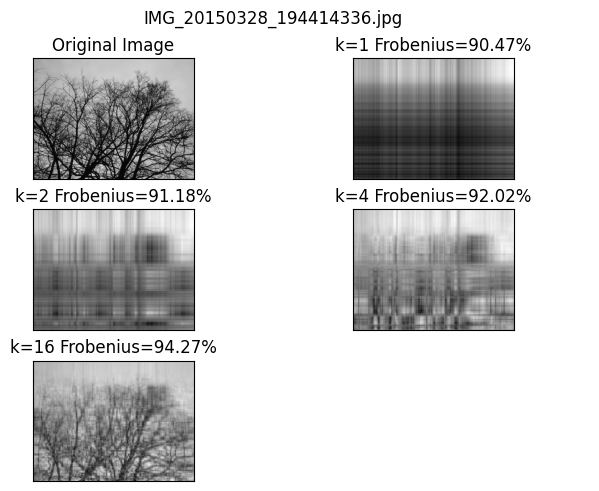

In [133]:
fig, axs = plt.subplots(3, 2, layout='constrained')
axs = axs.flatten()
img_file = 'IMG_20150328_194414336.jpg'
fig.suptitle(f'{img_file}')
axs[0].imshow(image_matrices[img_file], cmap='gray')
axs[0].grid(False)
axs[0].set_xticks(ticks=[])
axs[0].set_yticks(ticks=[])
axs[0].set_title(f'Original Image')
for i, n_sing_val in enumerate(n_sing_vecs):
    axs[i + 1].imshow(generated_images[img_file][n_sing_val], cmap='gray')
    axs[i + 1].grid(False)
    axs[i + 1].set_xticks(ticks=[])
    axs[i + 1].set_yticks(ticks=[])
    proportion_fro_norm = np.linalg.matrix_norm(generated_images[img_file][n_sing_val]) * 100.0 / np.linalg.matrix_norm(image_matrices[img_file])
    axs[i + 1].set_title(f'k={n_sing_val} Frobenius={proportion_fro_norm:.2f}%')
axs[-1].grid(False)
axs[-1].set_xticks(ticks=[])
axs[-1].set_yticks(ticks=[])
axs[-1].set_frame_on(False)
plt.show()

Displaying 'Zinnia Poolside In June.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [41..289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [12..289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1..280].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..4294967295].


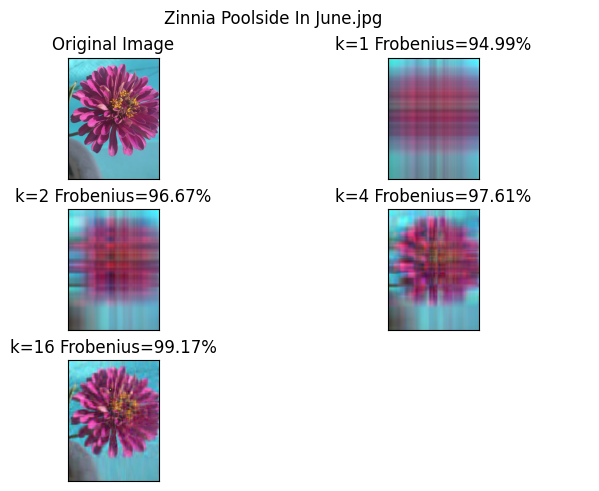

In [137]:
fig, axs = plt.subplots(3, 2, layout='constrained')
axs = axs.flatten()
img_file = 'Zinnia Poolside In June.jpg'
fig.suptitle(f'{img_file}')
axs[0].imshow(image_matrices[img_file])
axs[0].grid(False)
axs[0].set_xticks(ticks=[])
axs[0].set_yticks(ticks=[])
axs[0].set_title(f'Original Image')
for i, n_sing_val in enumerate(n_sing_vecs):
    axs[i + 1].imshow(generated_images[img_file][n_sing_val].astype('uint32'))
    axs[i + 1].grid(False)
    axs[i + 1].set_xticks(ticks=[])
    axs[i + 1].set_yticks(ticks=[])
    proportion_fro_norm = np.linalg.matrix_norm(generated_images[img_file][n_sing_val].reshape(-1, 1)) * 100.0 / np.linalg.matrix_norm(image_matrices[img_file].reshape(-1, 1))
    axs[i + 1].set_title(f'k={n_sing_val} Frobenius={proportion_fro_norm:.2f}%')
axs[-1].grid(False)
axs[-1].set_xticks(ticks=[])
axs[-1].set_yticks(ticks=[])
axs[-1].set_frame_on(False)
plt.show()